This notebook recreates the toy model from the Ice cube experiment to understand how the neural net is set up, and have a comparison for performance.

See

https://github.com/philippeller/freeDOM/blob/master/notebooks/atfienberg/EML_decomposition.ipynb

https://github.com/philippeller/freeDOM/blob/master/notebooks/peller/toy_experiment_NNs.ipynb

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

from scipy import stats
from scipy import constants
from mpl_toolkits.axes_grid1 import make_axes_locatable
import types
from sklearn.model_selection import train_test_split

In [2]:
def rsq(x, x_src, b_src):
    # include finite size of sensor to avoid divide by 0 when scanning (x, b)
    return (x_src-x)**2 + b_src**2 + 0.05**2

#arrival time is normal distribution
arrival_time = lambda t: stats.norm(loc=t, scale=1)
c = constants.c*1e-9 # m/ns

#number of observed hits is poisson distribution
obs_hits = lambda N: stats.poisson(mu=N)

detector_loc = lambda n: np.linspace(-5,5,n)

x_toy = 2.45
b_toy = 1.1
N_toy = 2.3
N_det = 11

In [108]:
def generate_event(x_src, b=1, N_src=10, t_src=0, N_det=11):
    '''
    generates event
    
    Parameters:
    
    x_rsc : float
        Source position
    t_src : float
        Source time
    N_src : int
        Amount of photons sent out
    b : float
        perpendicaulr distance off of sensor line
    N_det : int
        Number of detectors/sensors
        
    Returns:
    
    Ns : list
        observed number of photons per detector
    ts : list
        observed photon times and detector index
    '''
    Ns = []
    ts = []
    t_idx = []
    for i,x in enumerate(detector_loc(N_det)):
        r2 = rsq(x,x_src,b)
        N_exp = N_src/r2
        N_obs = obs_hits(N_exp).rvs()
        Ns.append(N_obs)
        if N_obs > 0:
            t = arrival_time(t_src + np.sqrt(r2)/c).rvs(size=N_obs)
            ts.extend(t)
            #t_idx.extend([i]*N_obs)
            t_idx.extend([x]*N_obs)
    return np.array(Ns), np.array([ts,t_idx]).T

In [4]:
def generate_expectations(x_src, b=1, N_src=10, t_src=0, N_det=11):
    '''
    generates expected values (mean of distributions)
    
    Parameters:
    
    x_rsc : float
        Source position
    t_src : float
        Source time
    N_src : int
        Amount of photons sent out
    b : float
        perpendicaulr distance off of sensor line
    N_det : int
        Number of detectors/sensors
        
    Returns:
    
    Ns : list
        expected number of photons per detector
    ts : list
        expected pulse times
    '''
    Ns = []
    ts = []
    for x in detector_loc(N_det):
        r2 = rsq(x,x_src,b)
        N_exp = N_src/r2
        Ns.append(N_exp)
        t = t_src + np.sqrt(r2)/c
        ts.append(t)
    return Ns, ts

In [112]:
def plot_event(Ns, ts, x_src, b=1, N_src=10, t_src=0, N_det=11):
    
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.4)
    
    flat_axes = axes.flat
    
    ax = next(flat_axes)
    
    ax.set_title('hit times')
    ax.set_xlabel('t (ns)')
    
    color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    
    det_xs = detector_loc(N_det)
    
    for i, x_det in enumerate(det_xs):
        #expectation
        r2 = rsq(x_det,x_src,b)
        t_dist = arrival_time(t_src + np.sqrt(r2)/c)
        mu = t_dist.mean()
        std = t_dist.std()
        times = np.linspace(mu - 3*std, mu + 3*std, 1000)
        ax.plot(times, t_dist.pdf(times))
        
        #measured
        #sensor_times = ts[ts[:,1] == i][:,0]
        sensor_times = ts[ts[:,1] == x_det][:,0]
        if len(sensor_times) > 0:
            ax.bar(sensor_times, [0.25]*len(sensor_times), width=0.1, alpha=0.5,
                  color=color_cycle[i % len(color_cycle)])

    ax.set_yticklabels([])
    
    ax = next(flat_axes)
    for i, N in enumerate(Ns):
        ax.bar([det_xs[i]], [N], label=f'x={det_xs[i]:.0f} m')
    
    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.75))
        
    r2 = rsq(det_xs,x_src,b)
    N_exp = N_src/r2
    plt_xs = [det_xs[0] - 1] + list(det_xs) + [det_xs[-1] + 1]
    plt_ys = [0] + list(N_exp) + [0]
    ax.step(plt_xs, plt_ys, 'k--', where='mid', label='expected')
        
    ax.set_xlim(det_xs[0]-0.5, det_xs[-1] + 0.5)
        
    ax.set_yscale('log')
    ax.set_xlabel('x (m)')
    ax.set_ylabel('$Q_d$')
    ax.set_title('pulses per sensor')

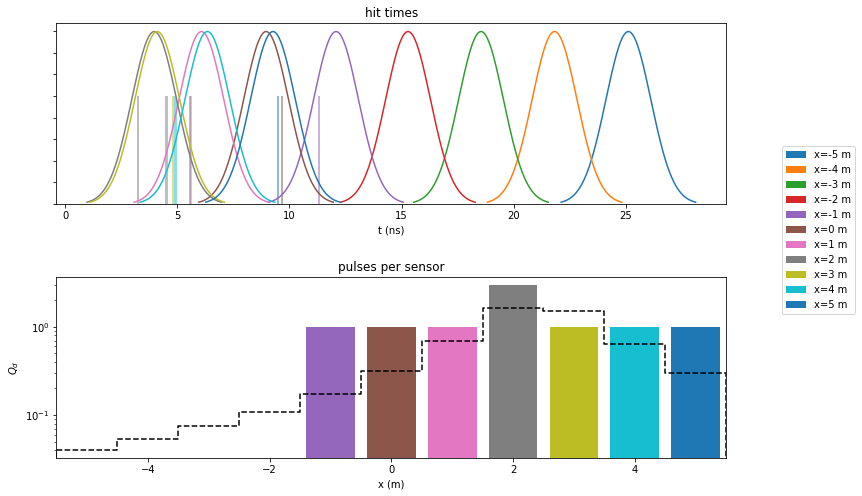

In [121]:
ev = generate_event(x_toy,b=b_toy,N_src=N_toy)
plot_event(*ev,x_toy,b=b_toy,N_src=N_toy)

In [117]:
#log-likelihoods

#def hit_pdf(ts, x_src, b=1, t_src=0, N_det=11):
#    x_det = detector_loc(N_det)
#    r2 = rsq(x_det,x_src,b)
#    t_exp = t_src + np.sqrt(r2)/c
#    
#    t_std = 1.
#    # t_std could in principle vary with the hypothesis, even though it doesn't in this example
#    llh = 0
#   
#    for hit in ts:
#        t_det = hit[0]
#        i = int(hit[1])
#        llh += -(t_det-t_exp[i])**2/(2*t_std**2) - np.log(t_std) ##was originally +log?
#    
#    return llh

def hit_pdf(ts, x_src, b=1, t_src=0, N_det=11):
    r2 = rsq(ts[:,1],x_src,b)
    t_exp = t_src + np.sqrt(r2)/c
    
    t_std = 1.
    # t_std could in principle vary with the hypothesis, even though it doesn't in this example
    llh = 0
    
    for i,t_det in enumerate(ts[:,0]):
        llh += -(t_det-t_exp[i])**2/(2*t_std**2) - np.log(t_std)
        
    return llh
        

def charge_pdf(Ns, x_src, b=1, N_src=10, N_det=11):
    x_det = detector_loc(N_det)
    r2 = rsq(x_det,x_src,b)
    N_exp = N_src/r2
    
    return (Ns*np.log(N_exp) - N_exp).sum()

In [8]:
def llh_scan(Ns, ts, param_table, N_det=11):
    '''
    the columns of param_table shall be ordered as follows:
    hypo_xs, hypo_bs, hypo_ts, hypo_n_srcs
    
    Returns:
    
    dom_hit_terms: np.array
    
    dom_charge_terms: np.array

    '''
    n_params = len(param_table)
    
    dom_hit_terms = np.empty(n_params)
    dom_charge_terms = np.empty(n_params)
    
    # store -llhs, multiply everything by -1
    for i in range(param_table.shape[0]):
        hypo_x, hypo_b, hypo_t, hypo_N_src = param_table[i, :]
    
        dom_hit_terms[i] = -hit_pdf(ts, hypo_x, b=hypo_b, t_src=hypo_t, N_det=N_det)
    
        dom_charge_terms[i] = -charge_pdf(Ns, hypo_x, b=hypo_b, N_src=hypo_N_src, N_det=N_det)
        
    return dom_hit_terms, dom_charge_terms

In [9]:
def map_1d(Ns, ts, ind, steps, base_x, base_b=1, base_t=0, base_N=10, N_det=11):
    
    n_hypotheses = steps.size
    
    base_params = np.array([base_x,base_b,base_t,base_N])
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    param_table[:, ind] = steps
           
    return llh_scan(Ns, ts, param_table, N_det=N_det)

def map_2d(Ns, ts, inds, steps, base_x, base_b=1, base_t=0, base_N=10, N_det=11):
           
    mg = np.meshgrid(*steps)
           
    n_hypotheses = mg[0].size
    
    base_params = np.array([base_x,base_b,base_t,base_N])
    param_table = np.repeat(base_params[np.newaxis, :], n_hypotheses, axis=0)

    for ind, coord in zip(inds, mg):
        param_table[:, ind] = coord.flat
           
    return llh_scan(Ns, ts, param_table, N_det=N_det)

In [10]:
def colorbar(mappable):
    # from https://joseph-long.com/writing/colorbars/
    #from mpl_toolkits.axes_grid1 import make_axes_locatable
    last_axes = plt.gca()
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    cbar = fig.colorbar(mappable, cax=cax)
    plt.sca(last_axes)
    cbar.ax.tick_params(labelsize=12)
    return cbar

def plot_1d_scan(llh_scan_res, xs, true_x, axis_label):
    # copy to avoid modifying original scan results
    dom_hits, dom_charge = np.copy(llh_scan_res)
    
    dom_terms = dom_hits, dom_charge
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.5)
    
    gridsize = len(xs)
    
    flat_axes = axes.flat

    ax = next(flat_axes)
        
    # subtract minimum value from each scan result
    for term in dom_terms:
        term[:] -= term.min()
    
    ax.plot(xs,dom_terms[0],label='scan')
    ax.axvline(x=true_x,color='red',label='truth')
        
    ax.set_xlabel(axis_label)
    ax.set_title(f'DOM hit term (Gaussian)')
        
    ax = next(flat_axes)
    ax.plot(xs,dom_terms[1],label='scan')
    ax.axvline(x=true_x,color='red',label='truth')
    
    ax.set_xlabel(axis_label)
    ax.set_title(f'DOM charge term (Poisson)')
    
    ax = next(flat_axes)
    sum_term = dom_terms[0]+dom_terms[1]
    sum_term = sum_term - sum_term.min()
    ax.plot(xs,sum_term,label='scan')
    ax.axvline(x=true_x,color='red',label='truth')
        
    ax.set_xlabel(axis_label)
    ax.set_title(f'DOM combined llh')
    

def plot_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, vmaxes):
    # copy to avoid modifying original scan results
    dom_hits, dom_charge = np.copy(llh_scan_res)
    
    dom_terms = dom_hits, dom_charge
    
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))
    plt.subplots_adjust(hspace=0.3)
    plt.subplots_adjust(wspace=0.5)
    
    gridsize = len(xs)
    
    flat_axes = axes.flat

    ax = next(flat_axes)
        
    # subtract minimum value from each scan result
    for term in dom_terms:
        term[:] -= term.min()
        
    m = ax.pcolormesh(xs, ys, dom_terms[0].reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmaxes[0])
        
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM hit term (Gaussian)')
    colorbar(m)
        
    ax = next(flat_axes)
    m = ax.pcolormesh(xs, ys, dom_terms[1].reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmaxes[1])
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM charge term (Poisson)')
    colorbar(m)
        
    ax = next(flat_axes)
    sum_term = dom_terms[0]+dom_terms[1]
    sum_term = sum_term - sum_term.min()
    m = ax.pcolormesh(xs, ys, sum_term.reshape(gridsize, gridsize), 
                          cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmaxes[2])
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(f'DOM combined llh')
    colorbar(m)

In [139]:
grid_spacing = 400

#xs = np.linspace(-5.5, 5.5, grid_spacing)
#bs = np.linspace(-2, 2, grid_spacing)
xs = np.linspace(-50, 50, grid_spacing) #larger range to check effect of big llhs
bs = np.linspace(-10, 10, grid_spacing) #larger range to check effect of big llhs

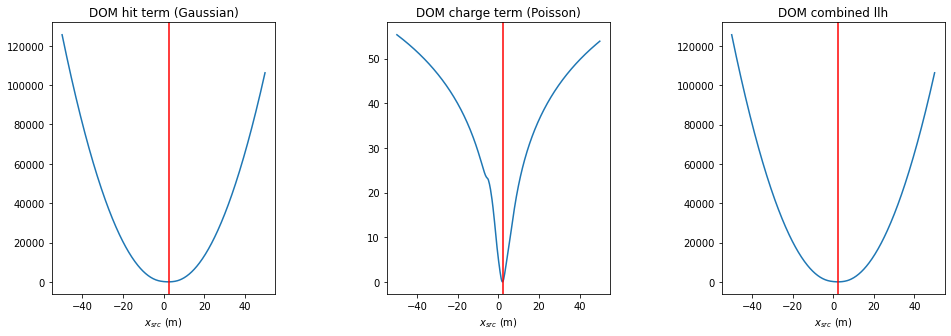

In [140]:
llh_x_scan_res = map_1d(*ev, 0, xs, x_toy, base_b=b_toy, base_N=N_toy)

plot_1d_scan(llh_x_scan_res, xs, x_toy, axis_label='$x_{src}$ (m)')

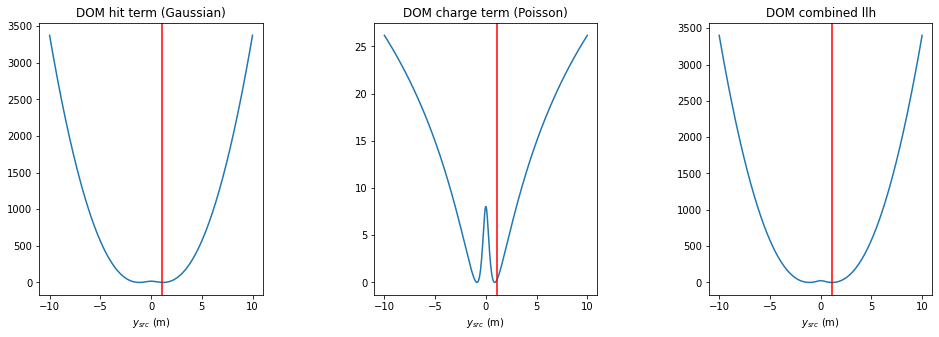

In [141]:
llh_b_scan_res = map_1d(*ev, 1, bs, x_toy, base_b=b_toy, base_N=N_toy)

plot_1d_scan(llh_b_scan_res, bs, b_toy, axis_label='$y_{src}$ (m)')

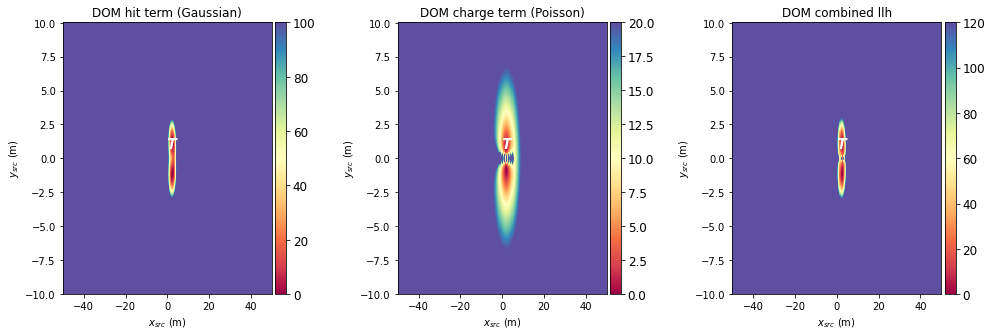

In [142]:
llh_pos_scan_res = map_2d(*ev, (0, 1), (xs, bs),x_toy,base_b=b_toy,base_N=N_toy)

plot_scan(llh_pos_scan_res, xs, bs, x_toy, b_toy,
                   axis_labels=['$x_{src}$ (m)', '$y_{src}$ (m)'], vmaxes=[100, 20, 120])

In [125]:
#b and energy
N_srcs = np.linspace(0.01, 5, grid_spacing)
N_srcs_bs = np.linspace(-0.5, 2, grid_spacing)

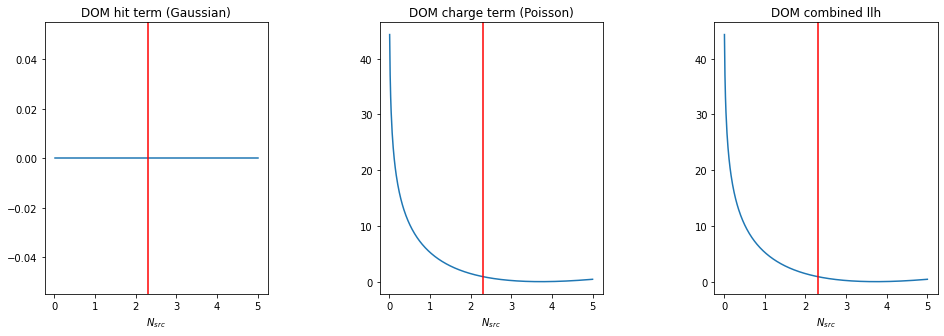

In [126]:
llh_N_scan_res = map_1d(*ev, 3, N_srcs, x_toy, base_b=b_toy, base_N=N_toy)

plot_1d_scan(llh_N_scan_res, N_srcs, N_toy, axis_label='$N_{src}$')

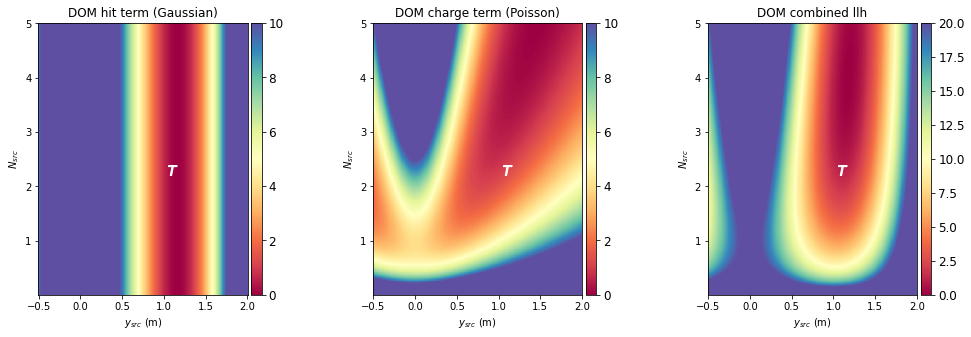

In [127]:
E_b_scan_res = map_2d(*ev, (1, 3), (N_srcs_bs, N_srcs), x_toy,base_b=b_toy,base_N=N_toy)

plot_scan(E_b_scan_res, N_srcs_bs, N_srcs, b_toy, N_toy,
                   axis_labels=['$y_{src}$ (m)', '$N_{src}$'], vmaxes=[10, 10, 20])

In [18]:
#toy MC
def MC_events(N_events, xlims=(-5, 5), blims=(-2,2), N_lims=(1,20), N_det=11):
    '''
    sample source parameters from uniform distribution of x, b, and N
    and generate events using those.
    N_events : int
        number of desired events
    *_lims : tuple
        lower and upper bount of the uniform to sample from
    N_det: int
        number of detectors in (-5,5)
    Returns:
    events : list of generated events
    truth : true parameters
    '''

    # truth array x, b, N

    x = np.random.uniform(*xlims, N_events)
    b = np.random.uniform(*blims, N_events)
    N = np.random.uniform(*N_lims, N_events)

    truth = np.vstack([x, b, N]).T

    events = []

    for i in range(N_events):
        events.append(generate_event(x[i], b=b[i], N_src=N[i], N_det=N_det))

    return events, truth

In [143]:
N_mc = int(1e5)
mc, truth = MC_events(N_mc, xlims=(-50,50), blims=(-10,10), N_lims=(0, 20))

In [144]:
#neural nets

hitnet = types.SimpleNamespace() #times
chargenet = types.SimpleNamespace() #number of hits

chargenet.events = []
hitnet.events = []
n_hits_per_event = []
for item in mc:
    chargenet.events.append(item[0])
    hitnet.events.append(item[1])
    n_hits_per_event.append(item[1].shape[0])

#chargenet.events = np.array(chargenet.events) ##if leaving it as set of N_det measurements
chargenet.events = np.concatenate(chargenet.events)   #each detector in separate row
chargenet.events = np.vstack((chargenet.events,np.tile(detector_loc(N_det),N_mc))).T    #add column of detector loc

hitnet.events = np.concatenate(hitnet.events)    #each hit in separate row
n_hits_per_event = np.array(n_hits_per_event)

#chargenet.truth = np.array(truth) ##if leaving it as set of N_det measurements
chargenet.truth = np.repeat(truth, N_det, axis=0)
hitnet.truth = np.repeat(truth, n_hits_per_event, axis=0)

assert chargenet.events.shape[0] == chargenet.truth.shape[0]
assert hitnet.events.shape[0] == hitnet.truth.shape[0]

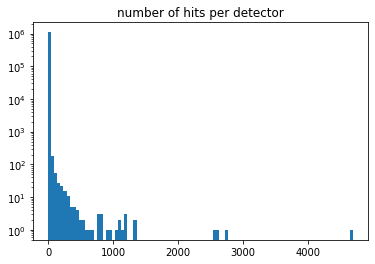

In [145]:
#plt.hist(chargenet.events.flatten(), bins=100)
plt.hist(chargenet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('number of hits per detector')
plt.show()

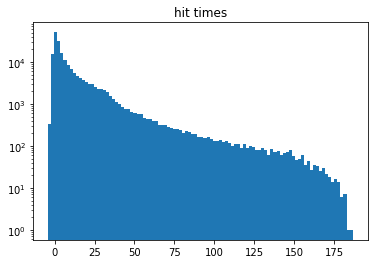

In [146]:
plt.hist(hitnet.events[:,0], bins=100)
plt.gca().set_yscale('log')
plt.title('hit times')
plt.show()

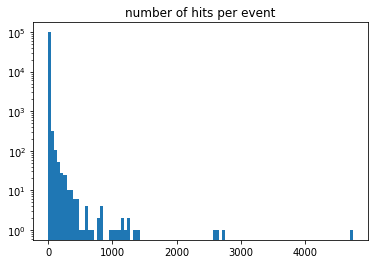

In [147]:
plt.hist(n_hits_per_event, bins=100)
plt.gca().set_yscale('log')
plt.title('number of hits per event')
plt.show()

In [148]:
def make_dataset(x, t, shuffle_block_size=2**15, batch_size=2**12):
        '''
        get a tensorflow dataset for likelihood approximation
        
        Parameters:
        -----------
        x : ndarray
            observations
        t : ndarray
            parameters        
        shuffle_block_size : int
            block size over which to shuffle, should be multiple of batch_size
        batch_size : int
        
        Returns:
        --------
        
        tf.data.Dataset
            with structure ((x, t), y) for training
        
        '''
        
        N = x.shape[0]
        assert t.shape[0] == N
        
        d_x = tf.data.Dataset.from_tensor_slices(x)
        d_t = tf.data.Dataset.from_tensor_slices(t)

        d_true_labels = tf.data.Dataset.from_tensor_slices(np.ones((N, 1), dtype=x.dtype))
        d_false_labels = tf.data.Dataset.from_tensor_slices(np.zeros((N, 1), dtype=x.dtype))

        d_xs = tf.data.Dataset.from_tensor_slices([d_x, d_x]).interleave(lambda x : x)
        d_ts = tf.data.Dataset.from_tensor_slices([d_t, d_t.shuffle(shuffle_block_size)]).interleave(lambda x : x)
        d_ys = tf.data.Dataset.from_tensor_slices([d_true_labels, d_false_labels]).interleave(lambda x : x)
        
        
        dataset = tf.data.Dataset.zip((tf.data.Dataset.zip((d_xs, d_ts)), d_ys))
  
        return dataset.batch(batch_size)



In [149]:
## charge net

chargenet.x_train, chargenet.x_test, chargenet.t_train, chargenet.t_test = train_test_split(chargenet.events, chargenet.truth, test_size=0.2, random_state=42)

chargenet.d_train = make_dataset(chargenet.x_train, chargenet.t_train)
chargenet.d_test = make_dataset(chargenet.x_test, chargenet.t_test)

#put make_dataset in trafo so it's redone every epoch?

In [150]:
class trafo(tf.keras.layers.Layer):

    def call(self, charges, theta):
        r2 = tf.math.square(theta[:,0] - charges[:,1]) + tf.math.square(theta[:,1])
#        r2 = tf.reshape(r2,[-1,1])
        out = tf.stack([
                 charges[:,0],
                 charges[:,1],
#                 charges[:,2],
                 r2,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )
#        out = tf.concat([charges[:,:1],r2,theta],axis=1)
        return out

#class trafo(tf.keras.layers.Layer):
#    def call(self, hits, theta):
#        locs = detector_loc(N_det)
#        r2 = tf.math.square(locs - tf.reshape(theta[:,0],[-1,1])) + tf.math.square(tf.reshape(theta[:,1],[-1,1]))
#        out = tf.concat([hits,r2,theta],axis=1)
        #out = tf.concat([hits,theta],axis=1)
#        return out
    
chargenet.trafo = trafo

In [151]:
activation='relu'

x_input = tf.keras.Input(shape=(chargenet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(chargenet.t_train.shape[1],))

h = chargenet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(128, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

chargenet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
chargenet.model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_31 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_32 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_15 (trafo)                (None, 6)            0           input_31[0][0]                   
                                                                 input_32[0][0]                   
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 32)           224         trafo_15[0][0]             

In [152]:
optimizer = tf.keras.optimizers.Adam(0.001)
chargenet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

chargenet.hist = chargenet.model.fit(chargenet.d_train, epochs=10, verbose=1, validation_data=chargenet.d_test)

Epoch 1/10
430/430 [==============================] - 23s 52ms/step - loss: 2.1060 - val_loss: 0.6866
Epoch 2/10
430/430 [==============================] - 23s 54ms/step - loss: 0.6900 - val_loss: 0.6834
Epoch 3/10
430/430 [==============================] - 24s 55ms/step - loss: 0.6840 - val_loss: 0.6824
Epoch 4/10
430/430 [==============================] - 23s 54ms/step - loss: 0.6829 - val_loss: 0.6820
Epoch 5/10
430/430 [==============================] - 23s 53ms/step - loss: 0.6823 - val_loss: 0.6818
Epoch 6/10
430/430 [==============================] - 23s 53ms/step - loss: 0.6823 - val_loss: 0.6812
Epoch 7/10
430/430 [==============================] - 24s 55ms/step - loss: 0.6818 - val_loss: 0.6812
Epoch 8/10
430/430 [==============================] - 23s 54ms/step - loss: 0.6818 - val_loss: 0.6808
Epoch 9/10
430/430 [==============================] - 25s 57ms/step - loss: 0.6815 - val_loss: 0.6810
Epoch 10/10
430/430 [==============================] - 26s 59ms/step - loss: 0.680

dict_keys(['loss', 'val_loss'])


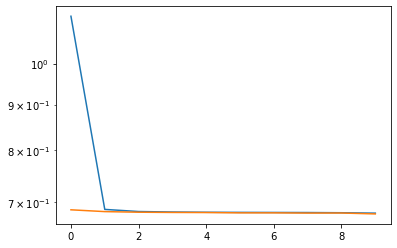

In [153]:
print(chargenet.model.history.history.keys())

plt.plot(chargenet.model.history.history['loss'])
plt.plot(chargenet.model.history.history['val_loss'])
plt.gca().set_yscale('log')
plt.show()

chargenet.llh = tf.keras.models.clone_model(chargenet.model)
chargenet.llh.set_weights(chargenet.model.get_weights())
chargenet.llh.layers[-1].activation = tf.keras.activations.linear
chargenet.llh.compile()

In [32]:
def plot_NN_scan(llh_scan_res, xs, ys, true_x, true_y, axis_labels, title, vmax):
    # copy to avoid modifying original scan results
    scan = np.copy(llh_scan_res)
    
    gridsize = len(xs)
    
    fig,ax = plt.subplots()
    
    m = ax.pcolormesh(xs, ys, scan, 
                          cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmax)
        
    ax.plot([true_x], [true_y], marker='$T$', markersize=10, color='white')
        
    ax.set_xlabel(axis_labels[0])
    ax.set_ylabel(axis_labels[1])
    ax.set_title(title)
    colorbar(m)

In [44]:
def plot_1d_diff(theory, nn, xs, true_x, axis_label,scale=False):
    
    scan_a = np.copy(theory)
    scan_a -= scan_a.min()
    
    scan_b = np.copy(nn)
    scan_b -= scan_b.min()
    
    a_label='Analytic'
    if scale: 
        scan_a *= scan_b.max()/scan_a.max()
        a_label += ' (scaled)'
    
    plt.plot(xs,scan_a,label=a_label)
    plt.plot(xs,scan_b,label='Neural net')
    
    #diff = scan_a - scan_b
    
    #plt.plot(xs,diff,label='difference')
    
    plt.axvline(x=true_x,color='red',label='truth')
    plt.xlabel(axis_label)
    plt.ylabel('log likelihood')
    plt.legend()

def plot_2d_diff(theory, nn, xs, ys, true_x, true_y, axis_labels, vmax=None, vmax_diff = None, scale=False, **kwargs):
    
    gridsize = xs.size
    assert ys.size==gridsize
    
    fig,ax = plt.subplots(1,3,figsize=(23,7))
    plt.subplots_adjust(wspace=0.5)
    
    scan_a = np.copy(theory).reshape(gridsize,gridsize)
    scan_a -= scan_a.min()
    
    scan_b = np.copy(nn).reshape(gridsize,gridsize)
    scan_b -= scan_b.min()
    
    if scale: scan_a *= scan_b.max()/scan_a.max()
    
    m1 = ax[0].pcolormesh(xs, ys, scan_a, cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    ax[0].set_title('Analytic')
    ax[0].set_xlabel(axis_labels[0])
    ax[0].set_ylabel(axis_labels[1])
    colorbar(m1)
    
    m2 = ax[1].pcolormesh(xs, ys, scan_b, cmap='Spectral', rasterized=True, shading='auto', linewidth=0, vmin=0, vmax=vmax, label=r'$\Delta LLH$', **kwargs)
    ax[1].set_title('Neural net')
    ax[1].set_xlabel(axis_labels[0])
    ax[1].set_ylabel(axis_labels[1])
    colorbar(m2)
    
    diff = scan_a - scan_b
    if not vmax_diff: vmax_diff=np.max(np.abs(diff))
    md = ax[2].pcolormesh(xs, ys, diff, cmap='RdBu', shading='auto', vmin=-vmax_diff, vmax=vmax_diff, label=r'$\Delta LLH$', **kwargs)
    #md = axes[2].pcolormesh(xs, ys, diff, cmap='RdBu', vmin=-100, vmax=100, label=r'$\Delta LLH$', **kwargs)
    ax[2].set_title('diff')
    ax[2].set_xlabel(axis_labels[0])
    ax[2].set_ylabel(axis_labels[1])
    colorbar(md)
    
    for axis in ax.flatten():
        axis.plot([true_x], [true_y], marker='$T$', markersize=10, color='black')

In [154]:
grid_spacing = 100


xs = np.linspace(-5.5, 5.5, grid_spacing)
bs = np.linspace(-2, 2, grid_spacing)

In [155]:
chargenet.scan_t = np.vstack([xs,b_toy*np.ones(grid_spacing), N_toy*np.ones(grid_spacing)]).T
chargenet.scan_t = np.repeat(chargenet.scan_t,N_det,axis=0)

chargenet.scan_x = np.tile(ev[0],grid_spacing)
chargenet.scan_x = np.vstack((chargenet.scan_x,np.tile(detector_loc(N_det),grid_spacing))).T

chargenet.scan_llh = chargenet.llh.predict([chargenet.scan_x,chargenet.scan_t])

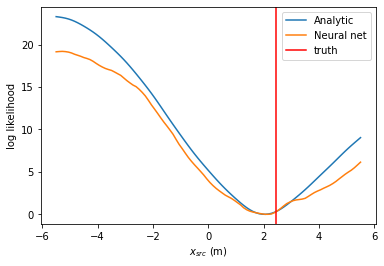

In [156]:
NN_pos_scan_res = -np.sum(chargenet.scan_llh.reshape(-1, N_det), axis=1)

llh_x_scan_res = map_1d(*ev, 0, xs, x_toy, base_b=b_toy, base_N=N_toy)[1]

plot_1d_diff(llh_x_scan_res, NN_pos_scan_res, xs, x_toy, axis_label="$x_{src}$ (m)")

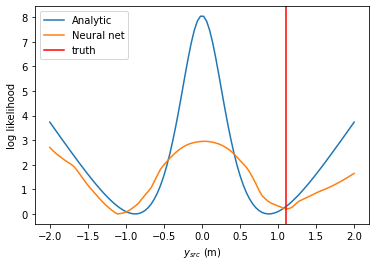

In [157]:
chargenet.scan_t = np.vstack([x_toy*np.ones(grid_spacing),bs, N_toy*np.ones(grid_spacing)]).T
chargenet.scan_t = np.repeat(chargenet.scan_t,N_det,axis=0)

chargenet.scan_llh = chargenet.llh.predict([chargenet.scan_x,chargenet.scan_t])

NN_pos_scan_res = -np.sum(chargenet.scan_llh.reshape(-1, N_det), axis=1)

llh_b_scan_res = map_1d(*ev, 1, bs, x_toy, base_b=b_toy, base_N=N_toy)[1]

plot_1d_diff(llh_b_scan_res, NN_pos_scan_res, bs, b_toy, axis_label="$y_{src}$ (m)")

In [158]:
mg = np.meshgrid(xs,bs)

chargenet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*N_toy]).T
chargenet.grid_t = np.repeat(chargenet.grid_t,N_det,axis=0)

chargenet.grid_x = np.tile(ev[0],grid_spacing**2)#.reshape((-1,N_det))
chargenet.grid_x = np.vstack((chargenet.grid_x,np.tile(detector_loc(N_det),grid_spacing**2))).T

chargenet.grid_llh = chargenet.llh.predict([chargenet.grid_x,chargenet.grid_t])

In [159]:
NN_pos_scan_res = -np.sum(chargenet.grid_llh.reshape(-1, N_det), axis=1).reshape(grid_spacing,grid_spacing)
#NN_pos_scan_res = -1*chargenet.grid_llh.reshape(grid_spacing,grid_spacing)
NN_pos_scan_res -= np.min(NN_pos_scan_res)

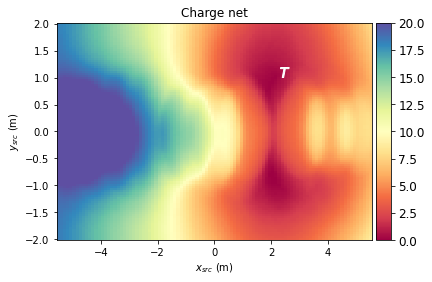

In [160]:
NN_plot = plot_NN_scan(NN_pos_scan_res, xs, bs, x_toy, b_toy,
                   axis_labels=['$x_{src}$ (m)', '$y_{src}$ (m)'], title='Charge net', vmax=20)

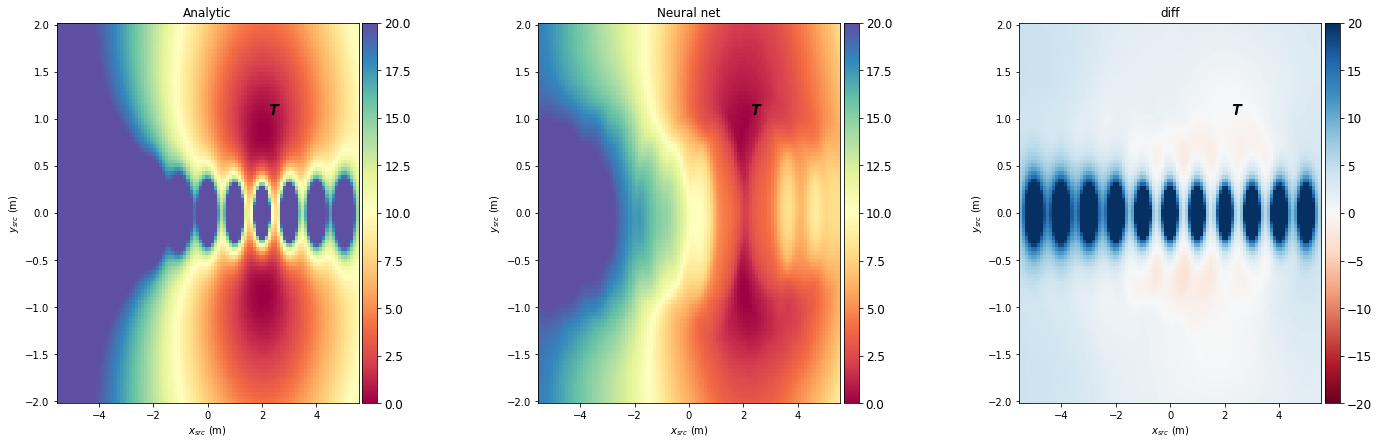

In [161]:
llh_pos_scan_res = map_2d(*ev, (0, 1), (xs, bs),x_toy,base_b=b_toy,base_N=N_toy)[1]

plot_2d_diff(llh_pos_scan_res, NN_pos_scan_res, xs, bs, x_toy, b_toy, ["$x_{src}$ (m)","$y_{src}$ (m)"], vmax=20,vmax_diff=20)

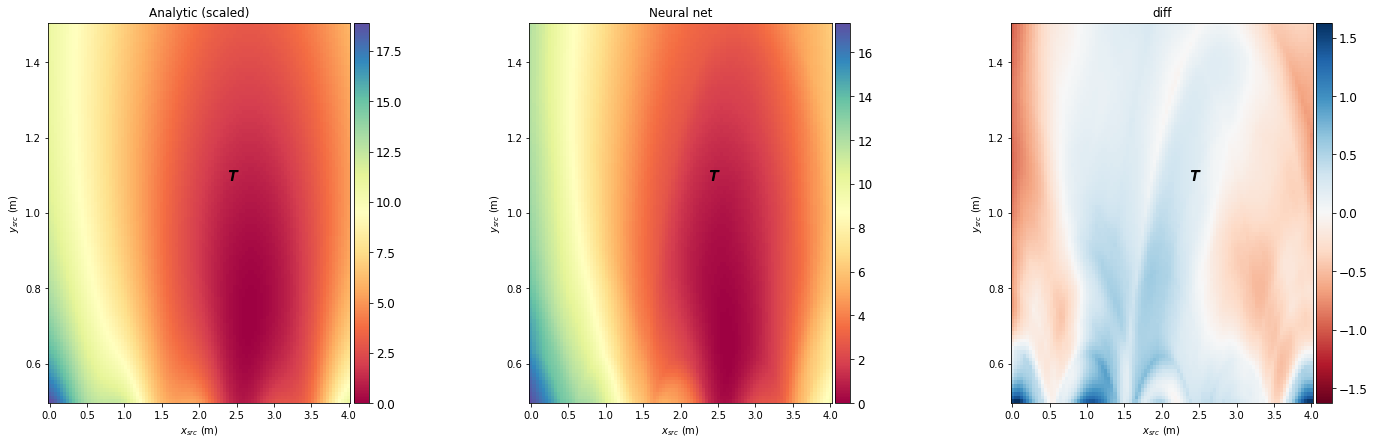

In [45]:
grid_spacing = 100


xs = np.linspace(0, 4, grid_spacing)
bs = np.linspace(0.5, 1.5, grid_spacing)

mg = np.meshgrid(xs,bs)

chargenet.grid_t = np.vstack([mg[0].flatten(),mg[1].flatten(),np.ones(grid_spacing**2)*N_toy]).T
chargenet.grid_t = np.repeat(chargenet.grid_t,N_det,axis=0)

chargenet.grid_x = np.tile(ev[0],grid_spacing**2)#.reshape((-1,N_det))
chargenet.grid_x = np.vstack((chargenet.grid_x,np.tile(detector_loc(N_det),grid_spacing**2))).T

chargenet.grid_llh = chargenet.llh.predict([chargenet.grid_x,chargenet.grid_t])

NN_pos_scan_res = -np.sum(chargenet.grid_llh.reshape(-1, N_det), axis=1).reshape(grid_spacing,grid_spacing)

llh_pos_scan_res = map_2d(*ev, (0, 1), (xs, bs),x_toy,base_b=b_toy,base_N=N_toy)[1]

plot_2d_diff(llh_pos_scan_res, NN_pos_scan_res, xs, bs, x_toy, b_toy, ["$x_{src}$ (m)","$y_{src}$ (m)"])

In [162]:
## hit net
hitnet.x_train, hitnet.x_test, hitnet.t_train, hitnet.t_test = train_test_split(hitnet.events, hitnet.truth, test_size=0.2, random_state=42)

hitnet.d_train = make_dataset(hitnet.x_train, hitnet.t_train)
hitnet.d_test = make_dataset(hitnet.x_test, hitnet.t_test)

In [164]:
class trafo(tf.keras.layers.Layer):
    c = 0.3
    def call(self, hits, theta):
        r2 = tf.math.square(theta[:,0] - hits[:,1]) + tf.math.square(theta[:,1])
        r = tf.math.sqrt(r2)
        
        delta_t = hits[:,0] - r/self.c 
        
        out = tf.stack([
                 hits[:,0],
                 hits[:,1],
                 #hits[:,2],
                 r,
                 delta_t,
                 theta[:,0],
                 theta[:,1],
                 theta[:,2]
                ],
                axis=1
                )    
        return out
hitnet.trafo = trafo

In [165]:
activation='relu'

x_input = tf.keras.Input(shape=(hitnet.x_train.shape[1],))
t_input = tf.keras.Input(shape=(hitnet.t_train.shape[1],))

h = hitnet.trafo()(x_input, t_input)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(64, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(128, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

#h = tf.keras.layers.Dense(64, activation=activation)(h)
#h = tf.keras.layers.Dropout(0.01)(h)

h = tf.keras.layers.Dense(32, activation=activation)(h)
h = tf.keras.layers.Dropout(0.01)(h)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(h)

hitnet.model = tf.keras.Model(inputs=[x_input, t_input], outputs=outputs)
hitnet.model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_33 (InputLayer)           [(None, 2)]          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           [(None, 3)]          0                                            
__________________________________________________________________________________________________
trafo_16 (trafo)                (None, 7)            0           input_33[0][0]                   
                                                                 input_34[0][0]                   
__________________________________________________________________________________________________
dense_16 (Dense)                (None, 32)           256         trafo_16[0][0]             

In [166]:
optimizer = tf.keras.optimizers.Adam(0.001)
hitnet.model.compile(loss='binary_crossentropy', optimizer=optimizer)

hist = hitnet.model.fit(hitnet.d_train, epochs=4, verbose=1, validation_data=hitnet.d_test)

Epoch 1/4
77/77 [==============================] - 4s 43ms/step - loss: 0.4213 - val_loss: 0.2050
Epoch 2/4
77/77 [==============================] - 3s 42ms/step - loss: 0.2005 - val_loss: 0.1741
Epoch 3/4
77/77 [==============================] - 3s 41ms/step - loss: 0.1731 - val_loss: 0.1639
Epoch 4/4
77/77 [==============================] - 3s 41ms/step - loss: 0.1711 - val_loss: 0.1564


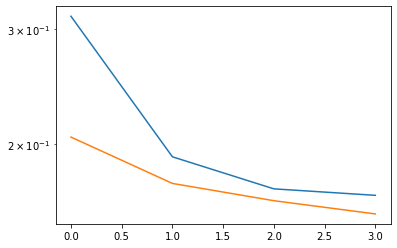

In [167]:
plt.plot(hitnet.model.history.history['loss'])
plt.plot(hitnet.model.history.history['val_loss'])
plt.gca().set_yscale('log')

hitnet.llh = tf.keras.models.clone_model(hitnet.model)
hitnet.llh.set_weights(hitnet.model.get_weights())
hitnet.llh.layers[-1].activation = tf.keras.activations.linear
hitnet.llh.compile()

In [168]:
grid_spacing = 100


xs = np.linspace(1, 4, grid_spacing)
bs = np.linspace(-2, 2, grid_spacing)

In [169]:
n_ev_hits = ev[1].shape[0]

hitnet.scan_t = np.vstack([xs,b_toy*np.ones(grid_spacing), N_toy*np.ones(grid_spacing)]).T
hitnet.scan_t = np.repeat(hitnet.scan_t,n_ev_hits,axis=0)

hitnet.scan_x = np.tile(ev[1][:,0],grid_spacing)
hitnet.scan_x = np.vstack((hitnet.scan_x,np.tile(ev[1][:,1],grid_spacing))).T

hitnet.scan_llh = hitnet.llh.predict([hitnet.scan_x,hitnet.scan_t])

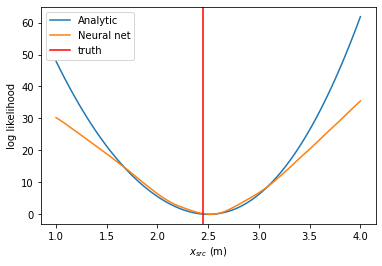

In [170]:
NN_pos_scan_res = -np.sum(hitnet.scan_llh.reshape(-1, n_ev_hits), axis=1)

llh_x_scan_res = map_1d(*ev, 0, xs, x_toy, base_b=b_toy, base_N=N_toy)[0]

plot_1d_diff(llh_x_scan_res, NN_pos_scan_res, xs, x_toy, axis_label="$x_{src}$ (m)")

#this isn't right because llh scan expects det ids, not positions
#def significantly smaller log likelihoods, zoom in for comparison closer to minimum

In [171]:
hitnet.scan_t = np.vstack([x_toy*np.ones(grid_spacing),bs, N_toy*np.ones(grid_spacing)]).T
hitnet.scan_t = np.repeat(hitnet.scan_t,n_ev_hits,axis=0)

hitnet.scan_llh = hitnet.llh.predict([hitnet.scan_x,hitnet.scan_t])

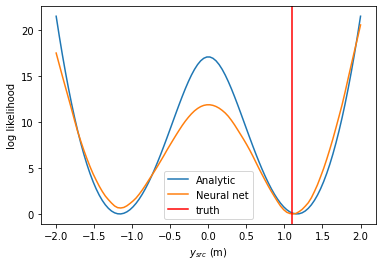

In [172]:
NN_pos_scan_res = -np.sum(hitnet.scan_llh.reshape(-1, n_ev_hits), axis=1)

llh_b_scan_res = map_1d(*ev, 1, bs, x_toy, base_b=b_toy, base_N=N_toy)[0]

plot_1d_diff(llh_b_scan_res, NN_pos_scan_res, bs, b_toy, axis_label="$y_{src}$ (m)")

In [ ]:
# this is still copy from original code, need to simplify to use functions defined here



# some nasty gymnastics to get the NN inputs for the grid scan
hitnet.tt = np.vstack([g.get_array('x', flat=True), g.get_array('b', flat=True), np.ones(np.prod(g.shape)) * example_N_src]).T
hitnet.tts = np.repeat(hitnet.tt, test_event[1].shape[0], axis=0)
hitnet.xxs = np.repeat(test_event[1][np.newaxis,:, :], np.prod(g.shape), axis=0)
hitnet.xxs = hitnet.xxs.reshape(-1, 3)

hitnet.llhs = hitnet.llh.predict([hitnet.xxs, hitnet.tts])

g['hit_llh'] = -np.sum(hitnet.llhs.reshape(-1, test_event[1].shape[0]), axis=1).reshape(g.shape)
g['hit_llh'] -= np.min(g['hit_llh'])

fig, ax = plt.subplots(1, 3, figsize=(20,5))
plt.subplots_adjust(wspace=0.3)

plot_diff(g['dom_hit_term'], g['hit_llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax)
plot_truth(ax, example_x_src, example_b_src)



g['llh'] = g['dom_llh'] + g['hit_llh']
g['llh'] -= np.min(g['llh'])





fig, ax = plt.subplots(3, 3, figsize=(20,18))
plt.subplots_adjust(wspace=0.3, hspace=0.3)

# Zoom in
#grid_to_plot = g[example_x_src-0.5:example_x_src+0.5, example_b_src-0.5:example_b_src+0.5]

grid_to_plot = g

plot_diff(grid_to_plot['dom_hit_term'], grid_to_plot['hit_llh'], title_a='Hit Analytic', title_b='Hit NN', vmax=20, axes=ax[0])
plot_diff(grid_to_plot['dom_charge_terms'], grid_to_plot['charge_llh'], title_a='Charge Analytic', title_b='Charge NN', vmax=20, axes=ax[1])
plot_diff(grid_to_plot['dom_llh'], grid_to_plot['llh'], title_a='Analytic', title_b='NN', vmax=20, axes=ax[2])

plot_truth(ax, example_x_src, example_b_src)

